##  **Clone the  YOLOv10 Github Repository**

In [ ]:
# prompt: pip install ultralytics
!pip install ultralytics==8.0.196

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from IPython.display import Image
from ultralytics import YOLOv10
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import torch
from imutils import paths
import numpy as np
import imutils

# Establashing the model

In [ ]:
import glob


model_path = '/content/drive/MyDrive/Final/best.pt'
model = YOLOv10(model_path)



In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0  31435      0 --:--:-- --:--:-- --:--:-- 31486


# Canny edge detector functions

In [ ]:
from scipy import ndimage
import cv2
from google.colab.patches import cv2_imshow
import torch
from imutils import paths
import numpy as np
import imutils

def detect_upper_cone_canny(image, cone_type):
  # return - upper triangle area size, (center of mass - x, center of mass - y)

  # Blue cone
  cv2_imshow(image)
  if cone_type == 0:
    HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Create a binary mask for the desired H values
    maskH = cv2.inRange(HSV[:,:,0], 255*(90/360), 255*(210/360))
    maskS = cv2.inRange(HSV[:,:,1], 90, 255)
    maskV = cv2.inRange(HSV[:,:,2], 40, 255)
    mask = cv2.bitwise_and(maskH, maskS, maskV)
    return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Apply Canny edge detection
  edges = cv2.Canny(gray, 50, 300)
  # Find contours in the edged image
  contours = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  # validation that the set isnt empty
  if len(contours) == 0:
        return None, None
  # return contour with maximum area
  cone_upper_triangle = max(contours, key=cv2.contourArea)
  # make the area convex hull
  cone_upper_triangle = cv2.convexHull(cone_upper_triangle)
  # convert to numpy array type int32
  cone_upper_triangle = np.array(cone_upper_triangle, dtype=np.int32)
  # Draw the detected triangles on the original image
  M = cv2.moments(cone_upper_triangle)
  center_of_mass = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
  # return the area size
  cone_upper_triangle_area = cv2.contourArea(cone_upper_triangle)
  [x,y] = gray.shape
  # skip when the deetection is bad
  if x*y//15 > cone_upper_triangle_area:
    return None, None
  return cv2.contourArea(cone_upper_triangle), center_of_mass


# usage:
def detect_upper_cone(img, bb, boxes):
  # bb - The Bounding Box limits. access through results[i].boxes.xyxy
  # i is the num of the frame
  num_of_cones = bb.shape[0]
  # preparation
  cone_upper_triangle = np.zeros(num_of_cones)
  center_of_mass = np.zeros((num_of_cones,2))
  # loop over the bounding boxes
  for i in range(0,num_of_cones):
    # type of cone
    cone_type = boxes[i].cls[0]
    # temporary bounding boxes and their width and hight
    temp_bb = bb[i].type(torch.int).tolist()
    width = temp_bb[2] - temp_bb[0]
    hight = temp_bb[3] - temp_bb[1]
    # skip if the cone is too small
    if width < 25 or hight < 25:
      continue
    print('probs' + str(boxes[i].conf[0]))
    # skip if the detection with low confidence probability
    if boxes[i].conf[0] < 0.6:
      continue
    # cut upper triangle and customize size
    cone_upper_triangle[i], center_of_mass[i] = detect_upper_cone_canny(
     img[temp_bb[1] -hight//10:temp_bb[3]-2*hight//3+1,temp_bb[0] :temp_bb[2] ],
     cone_type)
    # update the original center of mass
    center_of_mass[i,1] += temp_bb[1]
    center_of_mass[i,0] += temp_bb[0]
  return (cone_upper_triangle, center_of_mass)
print(detect_upper_cone(img, results[0].boxes.xyxy, results[0].boxes.cpu()))


In [ ]:
imgs1 = {}
path = '/content/drive/MyDrive/Final/MyData/all_valid/Copy of '

for i in range(1,33):
  img_path = path + str(i) + '.jpg'
  imgs1[i-1] = cv2.imread(img_path)


# Displaying an example of our distance data set

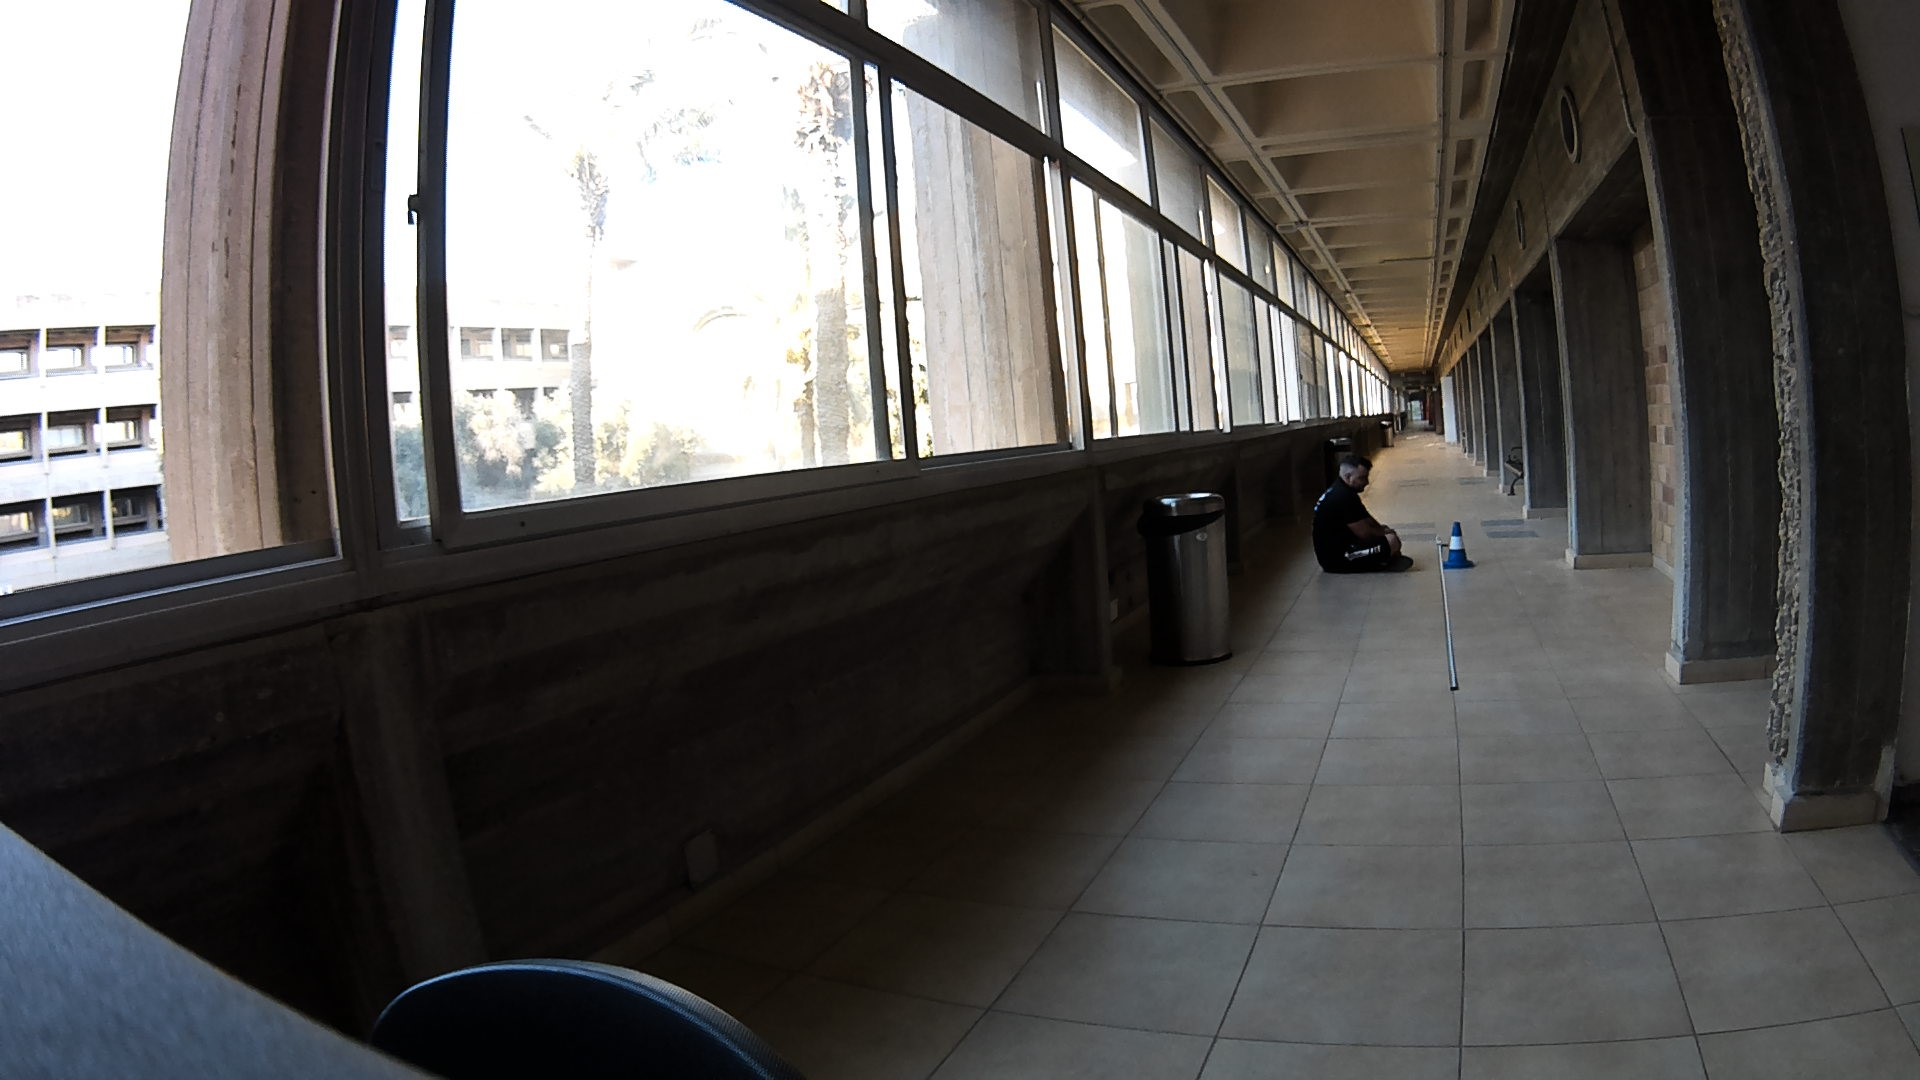

In [ ]:
cv2_imshow(imgs1[25])

In [ ]:
model_path = '/content/drive/MyDrive/Final/best.pt'
model = YOLOv10(model_path)
areas = np.zeros(32)
com = np.zeros((32,2))
for i in range(0,32):
  results = model(imgs1[i], conf=0.25,save=True)
  tempArea, tempCom = detect_upper_cone(imgs1[i], results[0].boxes.xyxy, results[0].boxes.cpu())
  print(tempArea, tempCom)
  areas[i] = tempArea[0]
  com[i] = tempCom[0]


#Running the model on our video data set for angle

In [ ]:
#run
vid_results10 = model('/content/drive/MyDrive/Final/new angles/d-0.mp4', conf=0.25,save=True, device='cpu')



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/428) /content/drive/MyDrive/Final/new angles/d-0.mp4: 384x640 1 blue_cone, 306.8ms
video 1/1 (frame 2/428) /content/drive/MyDrive/Final/new angles/d-0.mp4: 384x640 1 blue_cone, 319.7ms
video 1/1 (frame 3/428) /content/drive/MyDrive/Final/new angles/d-0.mp4: 384x640 1 blue_cone, 328.9ms
video 1/1 (frame 4/428) /content/drive/MyDrive/Final/new angles/d-0.mp4: 384x640 1 blue_cone, 323.4ms
video 1/1 (frame 5/428) /content/drive/MyDrive/F

# Function to estimate the angle

---



In [ ]:
import numpy as np

def polyval2d(p, x, y, n, m):
    """
    Evaluate a 2-D polynomial using Horner's method with 1D arrays for x, y, and coefficients p.

    Parameters:
    - p: 1D array of polynomial coefficients in a specific order
    - x: 1D array of x values
    - y: 1D array of y values
    - n: order of x
    - m: order of y

    Returns:
    - f: evaluated polynomial values, same shape as x and y
    """
    # Convert inputs to numpy arrays
    p = np.array(p, dtype=float)
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    if x.shape != y.shape:
        raise ValueError("x and y must have the same dimensions.")

    # Ensure the size of p matches the specified orders n and m
    expected_size = (n + 1) * (m + 1)
    if p.size != expected_size:
        raise ValueError("The size of the coefficient array p does not match the specified orders n and m.")

    # Initialize the result
    f = np.zeros_like(x)

    # Polynomial evaluation using Horner's method
    for mi in range(m + 1):
        # Index of the start of the coefficient block for this y term
        start_index = mi * (n + 1)
        # Evaluate polynomial for fixed y and varying x
        g = p[start_index] * np.ones_like(x)
        for ni in range(n):
            g = g * x + p[start_index + ni + 1]
        # Combine with polynomial terms for varying y
        f = f * y + g

    return f

# Calculating the angle for each frame of our data set

In [ ]:

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

X1_train = np.loadtxt('/content/drive/MyDrive/Final/xAngleData.txt')
Y1_train = np.loadtxt('/content/drive/MyDrive/Final/yAngleData.txt')
coeff_arr1 = [2.159*(10**(-8)), -3.3513*(10**(-5)), -2.4462*(10**(-5)), 0.0413, 0.0626, -66.1355]
def approximate_angle(input_array):
  coeff_arr = [2.159*(10**(-8)), -3.3513*(10**(-5)), -2.4462*(10**(-5)), 0.0413, 0.0626, -66.1355]
  angle = coeff_arr[0]*input_array[1]**(2)*input_array[0]**(1)+coeff_arr[1]*input_array[1]**(1)*input_array[0]**(1)+coeff_arr[2]*input_array[1]**(0)*input_array[0]**(1)+coeff_arr[3]*input_array[1]**(2)*input_array[0]**(0)+coeff_arr[4]*input_array[1]**(1)*input_array[0]**(0)+coeff_arr[5]*input_array[1]**(0)*input_array[0]**(0)
  return angle
total_sum = np.zeros(2363)
for i in range(2363):
  value = polyval2d(coeff_arr1, X1_train[i][0], X1_train[i][1], 1,2)
  total_sum[i] = value
  print(value)
average = np.nanmean(total_sum)
print("Average:", average)

1.211754173213925
1.2800015263766156
1.268100133352755
1.203227473795197
1.2512450049102952
1.248602312037021
1.2668745672616932
1.2020898660849992
1.1819911951728317
1.1286821512077605
1.119667730920126
1.128417318855801
1.1181202192877713
1.1435731041096862
1.1208892312928098
1.2173243561695788
1.2494726345863345
1.1840201519113744
1.195372831668732
1.1380310031280976
1.1703659594102795
1.1096611488352375
1.1583074534176232
1.1305156536793781
1.12062947171494
1.0325958302544969
1.2408631739397
1.187236823678739
1.2675872051506252
1.1811518112077337
1.2872467095341422
1.2851970873561243
1.3811975916916506
1.392588040802976
1.3555637857178828
1.3175051594140283
1.3844716683921998
1.3257549532553625
1.4245742797031813
1.4230874961893223
1.3035789306634769
1.3372480900080674
1.3207370684915993
1.3532769946887218
1.4402275689454145
1.4794867524330737
1.39581876708624
1.5243983488080417
1.5166671058217744
1.4531806308270507
1.4968650182299763
1.543672525370492
1.5245208247349487
1.49089656

428
width:  124
hight:  183


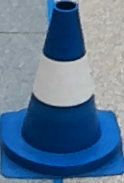

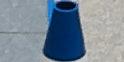

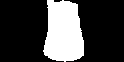

2021.0
[       2021] [[     991.83      951.31]]
0.7942492256929015
width:  122
hight:  184


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


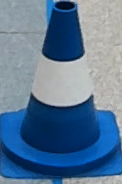

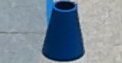

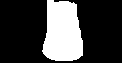

2009.0
[       2009] [[      992.9      950.37]]
0.8619180157694402
width:  124
hight:  184


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


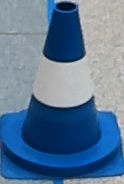

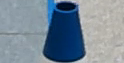

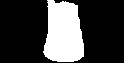

2021.0
[       2021] [[     992.69       950.3]]
0.8502671473303991
width:  123
hight:  184


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


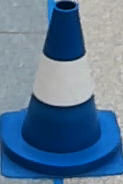

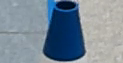

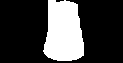

2009.0
[       2009] [[     991.69      951.35]]
0.7858468115570005
width:  125
hight:  185


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


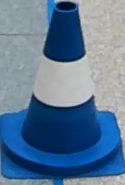

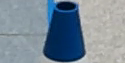

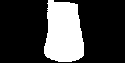

2021.0
[       2021] [[     992.31      949.33]]
0.834322648579608
width:  125
hight:  179


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


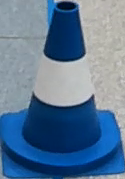

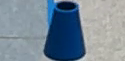

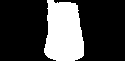

1998.0
[       1998] [[     991.97      946.48]]
0.8335196177070046
width:  126
hight:  176


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


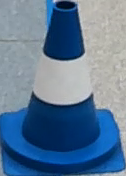

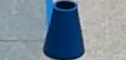

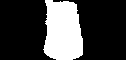

1976.0
[       1976] [[     991.91      942.65]]
0.853838888880837

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  125
hight:  174


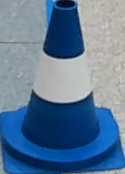

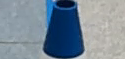

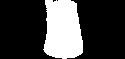

1942.0
[       1942] [[      990.6      940.55]]
0.7913343813373004
width:  125
hight:  175


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


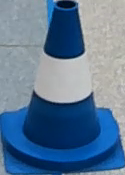

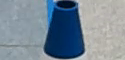

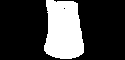

1930.0
[       1930] [[     990.04       938.3]]
0.772843878677584
width:  126
hight:  174


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


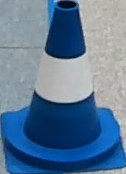

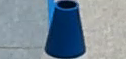

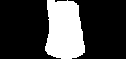

1921.0
[       1921] [[     989.01      937.09]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


0.7210431403813828
width:  124
hight:  172


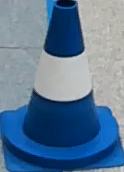

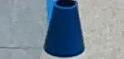

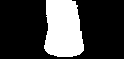

1905.0
[       1905] [[     988.74      935.93]]
0.7128055759041487
width:  125
hight:  171


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


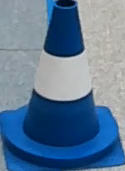

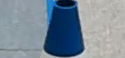

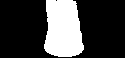

1877.0
[       1877] [[     988.69      933.82]]
0.7225639757496154
width:  125
hight:  172


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


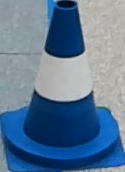

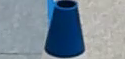

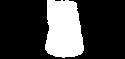

1865.0
[       1865] [[     988.18      930.36]]
0.7142417843349023
width:  124
hight:  169


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


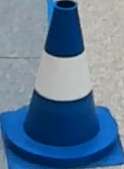

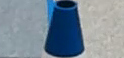

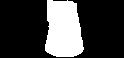

1823.0
[       1823] [[     988.22      926.14]]
0.7414828860142251
width:  123
hight:  168


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


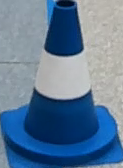

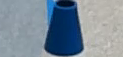

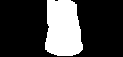

1782.0
[       1782] [[     987.34      920.74]]
0.7217269244055018
width:  123
hight:  167


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


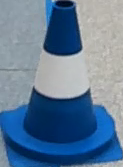

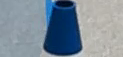

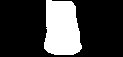

1731.0
[       1731] [[     988.26      912.52]]
0.8207101167372386
width:  121
hight:  163


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


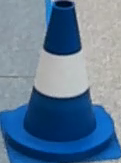

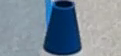

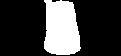

1690.0
[       1690] [[     988.17      905.04]]
0.8556992449397285
width:  123
hight:  164


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


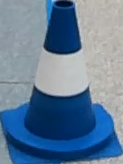

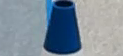

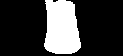

1642.0
[       1642] [[     986.56      899.34]]
0.7932012753535744
width:  121
hight:  163


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


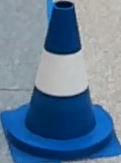

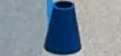

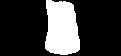

1586.0
[       1586] [[      986.2      892.44]]
0.8069597015717207
width:  117
hight:  158


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


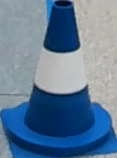

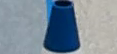

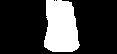

1529.0
[       1529] [[     984.75      886.66]]
0.7520812957992149
width:  117
hight:  157


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


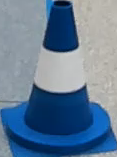

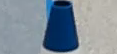

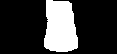

1463.0
[       1463] [[     984.72      878.95]]
0.7864978214194878
width:  117
hight:  156


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


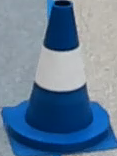

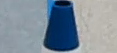

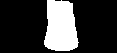

1425.0
[       1425] [[     983.26      873.42]]
0.7277900095869398
width:  114
hight:  152


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


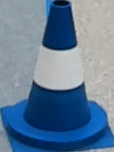

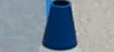

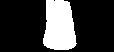

1375.0
[       1375] [[     983.64      866.94]]
0.7777275706673734
width:  114
hight:  150


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


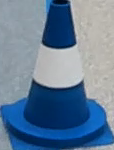

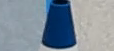

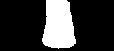

1315.0
[       1315] [[     982.84      862.33]]
0.7511866021165687
width:  112
hight:  147


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


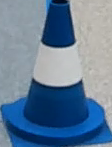

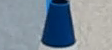

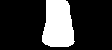

1259.0
[       1259] [[     982.29      856.81]]
0.7425247076700998
width:  114
hight:  146


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


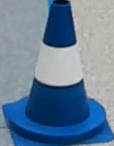

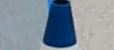

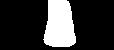

1231.0
[       1231] [[     980.47      852.28]]
0.6558348363601425
width:  111
hight:  146


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


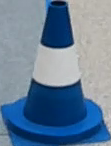

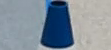

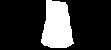

1205.0
width:  111
hight:  144


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


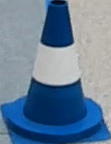

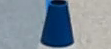

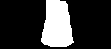

1199.0
[       1205        1199] [[      983.5      842.75]
 [     982.63      843.79]]
0.864684464240618
width:  108
hight:  143


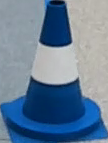

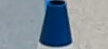

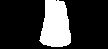

1165.0
[       1165] [[     983.58      836.29]]
0.8922671843725567
width:  106
hight:  139


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


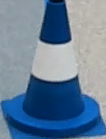

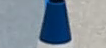

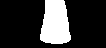

1088.0
[       1088] [[     981.83      832.03]]
0.806698368001129
width:  103
hight:  137


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


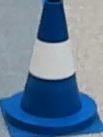

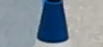

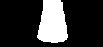

1039.0
[       1039] [[     983.27      824.38]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


0.9132861032660173
width:  105
hight:  137


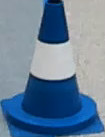

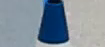

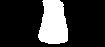

1050.0


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


[       1050] [[     982.96      819.11]]
0.9117229202670032
width:  103
hight:  136


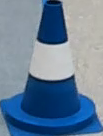

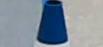

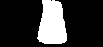

1030.0
[       1030] [[     984.39      813.89]]
1.0079064276589165
width:  103
hight:  135


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


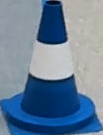

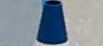

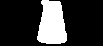

1025.0
[       1025] [[     984.44      810.68]]
1.0194888298524205
width:  102
hight:  133


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


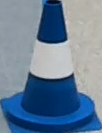

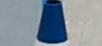

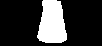

1003.0
[       1003] [[      983.7      808.78]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


0.9826404368521438
width:  103
hight:  133


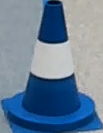

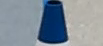

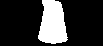

990.0
[        990] [[     982.92      806.38]]
0.9447624792754468
width: 

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 101
hight:  133


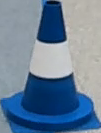

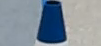

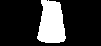

957.0
[        957] [[     983.87       801.2]]
1.0118215966720285
width:  100
hight:  130


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


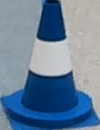

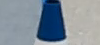

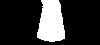

928.0
[        928] [[     982.66      796.88]]
0.9532711727355476
width:  96
hight:  127


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


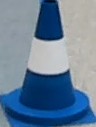

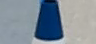

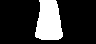

886.0
[        886] [[     984.07      788.55]]
1.0520338760940717
width:  95
hight:  126


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


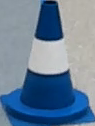

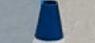

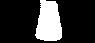

863.0
[        863] [[     983.79      781.55]]
1.0504219553279839

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  96
hight:  122


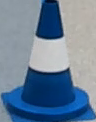

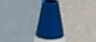

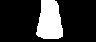

827.0
[        827] [[     981.58      778.35]]
0.9308331024026586


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


width:  94
hight:  122


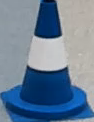

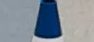

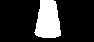

794.0
[        794] [[     981.99      772.62]]
0.9642047231146122
width:  93
hight:  119


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


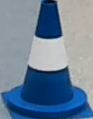

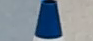

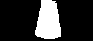

792.0
[        792] [[     981.59      769.02]]
0.9474623724356874
width:  92
hight:  118


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


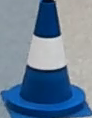

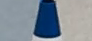

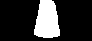

771.0
[        771] [[     982.07      765.74]]
0.9797639502876265
width:  88
hight:  117


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


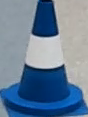

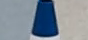

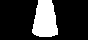

751.0
[        751] [[      983.5      761.72]]
1.0664086019880372
width:  87
hight:  116


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


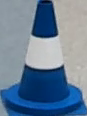

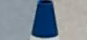

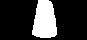

750.0
[        750] [[     984.06      756.39]]
1.105182777743849
width:  86
hight:  114


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


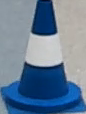

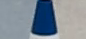

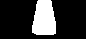

698.0
[        698] [[      982.5      752.83]]
1.0210811048899373
width:  83

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



hight:  112


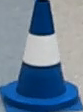

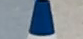

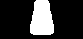

685.0
[        685] [[     984.61      744.52]]
1.1487153943366906
width:  81
hight:  111


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


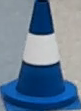

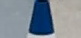

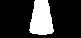

665.0
[        665] [[     984.38      739.05]]
1.140189558820147
width:  81
hight:  109


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


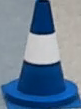

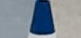

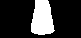

647.0
[        647] [[     983.19      734.92]]
1.075992769042962
width:  80
hight:  106


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


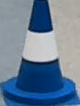

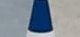

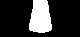

610.0
[        610] [[     983.91      731.08]]
1.1190666427989413
width:  78
hight:  104


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


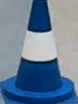

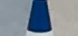

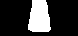

599.0
[        599] [[      984.7      727.01]]
1.1651851265258557
width:  79
hight:  105


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


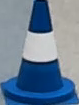

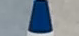

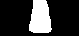

605.0
[        605] [[     984.34      724.91]]
1.1456162449744625
width:  79
hight:  104


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


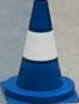

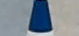

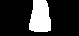

581.0
[        581] [[     983.72      722.85]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.111554444013045
width:  78
hight:  104


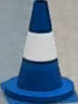

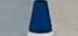

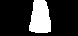

585.0
[        585] [[     984.43      717.88]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1527514745937282
width:  81
hight:  103


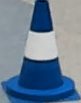

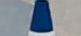

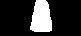

560.0
[        560] [[     983.06      715.02]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.0762246922388314
width:  78
hight:  100


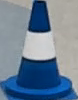

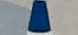

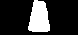

538.0
[        538] [[     985.43      707.78]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.2094505686026906
width:  73
hight:  100


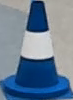

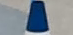

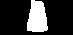

524.0
[        524] [[     986.23      701.91]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.2528680816107283
width:  73
hight:  98


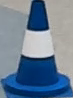

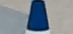

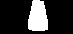

508.0
[        508] [[     984.52      700.55]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1567743573342497
width:  73
hight:  98


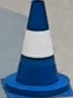

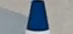

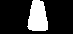

504.0
[        504] [[     984.59       698.4]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1600672209047787
width:  72
hight:  97


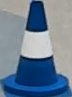

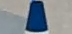

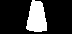

503.0
[        503] [[     986.29      695.37]]
1.2539887361140387
width:  72
hight:  97


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


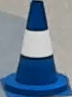

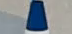

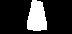

485.0
[        485] [[     985.66      694.48]]
1.2184507882880453
width:  74
hight:  96


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


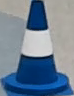

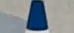

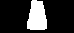

478.0
[        478] [[     985.19      693.72]]
1.1914140317359454
width:  71
hight:  97


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


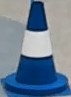

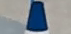

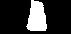

478.0
[        478] [[     986.96      689.55]]
1.288159357144977
width:  71
hight:  93


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


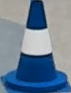

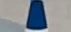

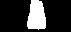

452.0
[        452] [[      985.5      687.24]]
1.205321314418299
width:  71
hight:  92


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


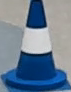

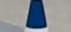

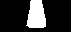

439.0
[        439] [[     984.74      684.03]]
1.1599665312308574
width:  69
hight:  92


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


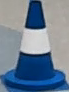

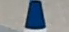

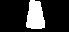

430.0
[        430] [[     986.51      678.93]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.2548563026801034
width:  70
hight:  91


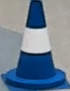

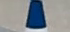

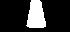

421.0
[        421]

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 [[        985      677.73]]
1.1692809145951202
width:  71
hight:  89


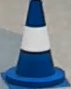

408.0
[        408] [[     984.23      676.27]]
1.1249755231271266
width:  71
hight:  89


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


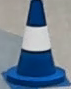

398.0
[        398] [[     983.02      674.93]]
1.0560995620694342
width:  69
hight:  87


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


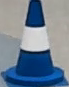

397.0
[        397] [[      984.2      670.72]]
1.1176968601592776
width:  68
hight:  87


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


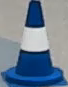

388.0
[        388] [[     984.94      666.47]]
1.1537010713386877
width:  66
hight:  84


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


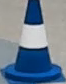

359.0
[        359] [[     984.03      664.38]]
1.1000371009842453
width:  66
hight:  84


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


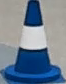

361.0
[        361] [[     984.79      658.94]]
1.135407350927494
width:  64
hight:  

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


83


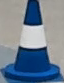

344.0
[        344] [[     984.22      656.61]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.0997568074313477
width:  66
hight:  81


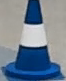

334.0
width:  64
hight:  81


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


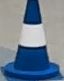

334.0
[        334         334] [[     982.53      656.29]
 [     983.53      655.29]]
1.0054082749673157
width:  63
hight:  80


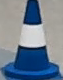

340.0
[        340] [[     984.06      653.16]]
1.085841676555681
width:  62
hight:  80


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


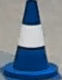

334.0
[        334]

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 [[     985.33      650.08]]
1.151280911107186
width:  62
hight:  79


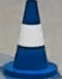

332.0
[        332] [[     985.03      648.06]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1311222266647718
width:  60
hight:  79


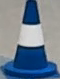

318.0
[        318] [[     984.85      644.93]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1155993182207453
width:  60
hight:  77


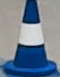

312.0
width:  25
hight:  39


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


0.0
[        312           0] [[     984.48      642.93]
 [        nan         nan]]
1.0911669042102545
width:  59
hight:  75


/usr/local/lib/python3.10/dist-packages/scipy/ndimage/_measurements.py:1542: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


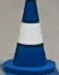

298.0
[        298           0] [[     985.12      640.23]
 [          0           0]]
1.1218048739102642
width:  57
hight:  75


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


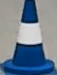

301.0
[        301           0] [[     986.03      637.35]
 [          0           0]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1664748645704037
width:  55
hight:  74


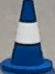

293.0
[        293           0] [[     987.84      634.58]
 [          0           0]]
1.2614270908304945

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  57
hight:  74


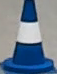

288.0
[        288] [[     986.57      634.83]]
1.1914447923023204
width:  57
hight:  73


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


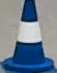

277.0
[        277] [[     986.35       633.1]]
1.1757266000970148
width:  55
hight:  72


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


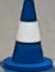

272.0
[        272] [[     987.36      629.24]]
1.2231309574648819
width:  55
hight:  71


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


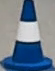

271.0
[        271] [[     987.41      626.17]]
1.2187435575876293
width:  57
hight:  

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


71


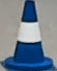

257.0
[        257] [[     986.85      624.15]]
1.1827070797409363
width: 

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 56
hight:  71


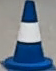

258.0
[        258] [[     986.95      622.16]]
1.1837050571265664
width:  57
hight:  70


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


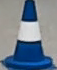

252.0
[        252] [[     986.15      622.25]]
1.1395378782189454


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


width:  55
hight:  72


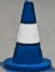

263.0
[        263]

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 [[     989.24      618.19]]
1.3008866047344227
width:  55
hight:  71


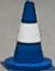

252.0
[        252] [[     987.73      617.86]]
1.2157334303119995
width:  53
hight:  72


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


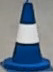

249.0
[        249] [[     989.69      613.43]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.3128494126059707
width:  54
hight:  70


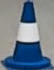

244.0
[        244] [[      987.8      612.95]]
1.2065071446910096

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  52
hight:  67


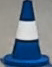

236.0
[        236] [[     987.19      611.89]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1702558708773907
width:  52
hight:  66


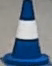

229.0
[        229] [[     986.37         611]]
1.121842696888578
width:  53
hight:  66


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


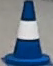

216.0
[        216] [[     985.94      610.08]]
1.0958492655202718
width:  50
hight:  66


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


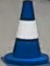

216.0
[        216] [[     986.81      608.23]]
1.1384012747357346
width:  49
hight:  64


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


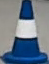

209.0
[        209] [[     986.97      607.24]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1445002155273798
width:  49
hight:  65


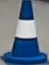

215.0
[        215] [[     987.18      605.24]]
1.1505960079220756
width:  50
hight: 

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 65


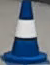

211.0
[        211] [[     986.89      602.76]]
1.1268658258364965
width:  49
hight:  63


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


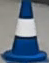

207.0
[        207] [[     986.41      601.71]]
1.097037478418919
width:  47
hight:  61


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


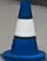

218.0
[        218]

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 [[     987.16      599.27]]
1.1313985026077376
width:  47
hight:  60


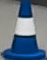

213.0
[        213] [[     986.62      599.25]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1013846815921937
width:  45
hight:  60


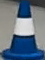

212.0
[        212] [[      987.6      597.33]]
1.1499041013508133
width:  46
hight:  59


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


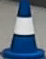

202.0
[        202] [[     987.33      597.32]]
1.134784675512016
width:  46
hight:  59


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


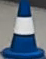

203.0
[        203] [[     987.26      596.19]]
1.127018047551033
width:  46
hight:  58


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


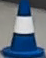

191.0
[        191] [[     986.82      595.17]]
1.0997205372102385
width:  44
hight:  58

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


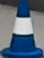

208.0
[        208] [[     988.21      591.42]]
1.16441495395798
width:  46
hight:  59


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


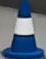

208.0
[        208] [[     987.96      590.42]]
1.1469858466250002
width:  45
hight:  58


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


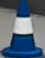

204.0
[        204] [[      988.5      587.91]]
1.1688146016765515
width: 

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 46
hight:  57


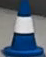

198.0
[        198] [[     987.33      587.93]]
1.1040617601217164

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  45
hight:  58


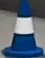

209.0
[        209] [[     988.02      585.97]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1355239448174217
width:  45
hight:  57


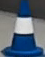

194.0
[        194] [[     987.85      584.94]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1220429549381379
width:  44
hight:  58


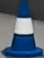

196.0
[        196] [[     988.64      582.67]]
1.1578634079742045
width:  43
hight:  58


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


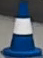

193.0
[        193] [[     989.67       579.8]]
1.2047944568410855

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



width:  42
hight:  57


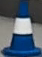

196.0
[        196] [[     989.45      578.97]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1896410755229923
width:  43
hight:  57


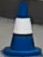

187.0
[        187] [[     989.96      577.91]]
1.2135499648592898
width:  43
hight:  56


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


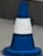

186.0
[        186] [[     989.72      577.13]]
1.1972433778165978
width:  43
hight:  56


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


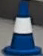

187.0
[        187] [[     989.25      577.13]]
1.1716252522700685
width:  43
hight:  56


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


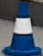

173.0
[        173] [[     990.08       575.9]]
1.2128744014733215
width:  43
hight:  56


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


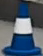

183.0
[        183] [[     989.97      575.03]]
1.2032899566948245
width:  42
hight:  54


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


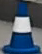

170.0
[        170] [[     990.25      574.14]]
1.2153685160984153
width:  42
hight:  53


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


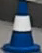

168.0
width:  42
hight:  53


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


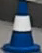

168.0
[        168         168] [[     989.16      574.18]
 [     989.16      574.18]]
1.1555210767485988
width:  42
hight:  52


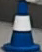

163.0
[        163] [[     988.85      573.17]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1346405963006916
width:  42
hight:  52


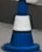

163.0
[        163] [[     989.01      572.26]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1399424153531825
width:  40
hight:  51


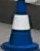

157.0
[        157] [[     989.16      571.24]]
1.1441077107446773
width:  41
hight:  50


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


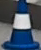

150.0
[        150] [[     987.86      572.25]]
1.0762678152834653
width:  41
hight:  50


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


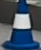

143.0
[        143] [[        988      571.17]]
1.0798094727798855
width: 

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


 41
hight:  50


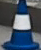

144.0
[        144] [[     988.67      569.07]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.1088126258458146
width:  41
hight:  51


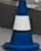

144.0
[        144] [[     989.03      567.24]]
1.1215103395287542
width:  40
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


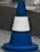

145.0
[        145] [[     990.73      564.23]]
1.203006813236101
width:  40
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


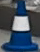

154.0
[        154] [[     990.32         564]]
1.1796181931064709
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


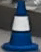

150.0
[        150] [[     990.63      563.79]]
1.1958089600898774
width:  40
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


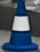

157.0
[        157] [[     990.18      563.92]]
1.1712287074369598
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


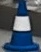

153.0
[        153] [[     989.27      564.91]]
1.125352417645253
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


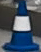

147.0
[        147] [[     989.16       564.8]]
1.1184071453892557
width:  41
hight:  53


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


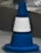

166.0
[        166] [[     989.87      563.89]]


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


1.153939265355305
width:  40
hight:  52


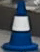

159.0
[        159] [[     990.18      563.83]]
1.1707227974041317
width:  41

<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)



hight:  52


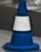

155.0
[        155] [[     989.12      564.88]]
1.1168400934130958
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


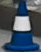

144.0
[        144] [[     989.03      564.68]]
1.1111913652841992
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


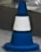

138.0
[        138] [[     989.07      564.67]]
1.1128476025430345
width:  41
hight:  52


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


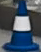

145.0
[        145] [[     989.34      564.52]]
1.1272634353570794


<ipython-input-7-b2884b93b807>:26: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  return np.sum(mask)/255, ndimage.measurements.center_of_mass(mask)


In [ ]:
print(len(vid_results10))
com10 = []

for i in range(0, len(vid_results10),3):
  tempArea, tempCom = detect_upper_cone(vid_results10[i].orig_img, vid_results10[i].boxes.xyxy, vid_results10[i].boxes.cpu())
  for j in range (0,len(tempCom)):
    if tempCom[j][0] != 0:
      com10.append(tempCom[j])
      j=len(tempCom)
  print(tempArea, tempCom)
  print(approximate_angle(tempCom))

# Example of how we calculated center of mass location of one of our videos of our data set

In [ ]:
com10final = []
for i in range(0, len(com10)):
  if com10[i][0] != 0:
    print(com10[i])
    com10final.append(com10[i])


[     991.83      951.31]
[      992.9      950.37]
[     992.69       950.3]
[     991.69      951.35]
[     992.31      949.33]
[     991.97      946.48]
[     991.91      942.65]
[      990.6      940.55]
[     990.04       938.3]
[     989.01      937.09]
[     988.74      935.93]
[     988.69      933.82]
[     988.18      930.36]
[     988.22      926.14]
[     987.34      920.74]
[     988.26      912.52]
[     988.17      905.04]
[     986.56      899.34]
[      986.2      892.44]
[     984.75      886.66]
[     984.72      878.95]
[     983.26      873.42]
[     983.64      866.94]
[     982.84      862.33]
[     982.29      856.81]
[     980.47      852.28]
[      983.5      842.75]
[     982.63      843.79]
[     983.58      836.29]
[     981.83      832.03]
[     983.27      824.38]
[     982.96      819.11]
[     984.39      813.89]
[     984.44      810.68]
[      983.7      808.78]
[     982.92      806.38]
[     983.87       801.2]
[     982.66      796.88]
[     984.07

# Function to approximate distance according to area

In [ ]:
import numpy as np

def approximate_function(x):
    # Your provided data
    x_data = np.array([1897, 1800 , 1710 , 1622 ,1544, 1502,  1426 , 1355, 1295, 1251 , 1190 , 1142 ,1103 ,1054, 1008, 969 ,925,887, 857, 824 , 803 , 101,  98 ,  98, 95, 94, 90, 91, 87, 85, 90 ,85, 84,  86,  83, 79 ,79 ,76 ,78 ,  74 ,70 ,75])
    y_data = np.array([1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 2.55, 2.6, 7, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8])
    # Fit a 8th degree polynomial
    coeffs = np.polyfit(x_data, y_data, 8)
    print(coeffs)
    # Create a polynomial function
    poly = np.poly1d(coeffs)
    # Return the y value for the given x
    return poly(x)



# With the coeff already calculated:

In [ ]:
def approximate_function(x):
    # Fit a 5th degree polynomial
    coeffs = [1.0046*10(-24), -1.3261*10**(-20), 6.9949*10**(-17), -1.9627*10**(-13), 3.2297*10**(-10),-3.1998*10**(-7), 0.00018684, -0.060422, 11.48]
    # Create a polynomial function
    poly = np.poly1d(coeffs)
    # Return the y value for the given x
    return poly(x)

# Example of how to run both angle and distance estimation:

In [ ]:
imgs = []
model_path = '/content/drive/MyDrive/Final/best.pt'
model = YOLOv10(model_path)
diss = np.zeros(len(imgs))
angs = np.zeros((len(imgs),2))
for i in range(0,len(imgs)):
  results = model(imgs1[i], conf=0.25,save=True)
  tempArea, tempCom = detect_upper_cone(imgs1[i], results[0].boxes.xyxy, results[0].boxes.cpu())
  angs[i] = approximate_angle(tempCom)
  diss[i] = approximate_function(tempArea)
